In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

In [ ]:
# ==========================================
# 1. CONFIGURATION & DATA PREPARATION
# ==========================================


# exact folder name seen in your printout
data_dir = 'real_vs_fake/real-vs-fake'

print(f"Looking for data in: {data_dir}")

# Define transformations (Resize to 224x224 for ResNet)
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the datasets
try:
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True) for x in ['train', 'test']}
    
    # --- SANITY CHECK PRINTOUT ---
    class_names = image_datasets['train'].classes
    print("\nSUCCESS! Data loaded correctly.")
    print(f"Classes found: {class_names}")
    print(f"Training images: {len(image_datasets['train'])}")
    print(f"Testing images:  {len(image_datasets['test'])}")
    
    # Check if classes are mapped correctly (0=FAKE, 1=REAL usually)
    print(f"Class Mapping: {image_datasets['train'].class_to_idx}")
    print("="*40)

except Exception as e:
    print(f"\nERROR: Could not find the folders. Check your path!\nError details: {e}")
    raise e

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ==========================================
# 2. MODEL SETUP (ResNet-18)
# ==========================================

# Load pre-trained ResNet
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Freeze the backbone (we only train the last layer for speed/accuracy balance)
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer
# Input features for last layer in ResNet18 is 512
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2) # 2 outputs: Real or Fake

model = model.to(device)

# Loss Function & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

print(f"Model has been setup!")

Looking for data in: real_vs_fake/real-vs-fake

✅ SUCCESS! Data loaded correctly.
Classes found: ['fake', 'real']
Training images: 100000
Testing images:  20000
Class Mapping: {'fake': 0, 'real': 1}
Using device: cuda:0
Model has been setup!


In [10]:
# ==========================================
# 3. TRAINING LOOP
# ==========================================

num_epochs = 5 
print(f"\nStarting Training for {num_epochs} epochs...")

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(image_datasets['train'])
    epoch_acc = correct / total
    print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    # --- Validation Phase (Quick Check) ---
    model.eval()
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
    val_acc = val_correct / val_total
    print(f'Val Acc:   {val_acc:.4f}\n')

print("Training Complete.")


Starting Training for 5 epochs...
Epoch 1/5
----------
Train Loss: 0.4725 Acc: 0.7759
Val Acc:   0.8020

Epoch 2/5
----------
Train Loss: 0.4443 Acc: 0.7926
Val Acc:   0.8034

Epoch 3/5
----------
Train Loss: 0.4418 Acc: 0.7973
Val Acc:   0.8006

Epoch 4/5
----------
Train Loss: 0.4430 Acc: 0.7954
Val Acc:   0.7807

Epoch 5/5
----------
Train Loss: 0.4417 Acc: 0.7965
Val Acc:   0.8023

Training Complete.



Generating Final Evaluation Report...

CLASSIFICATION REPORT
              precision    recall  f1-score   support

        fake       0.77      0.86      0.81     10000
        real       0.84      0.74      0.79     10000

    accuracy                           0.80     20000
   macro avg       0.81      0.80      0.80     20000
weighted avg       0.81      0.80      0.80     20000

Overall Accuracy: 0.8023
ROC-AUC Score:    0.8883


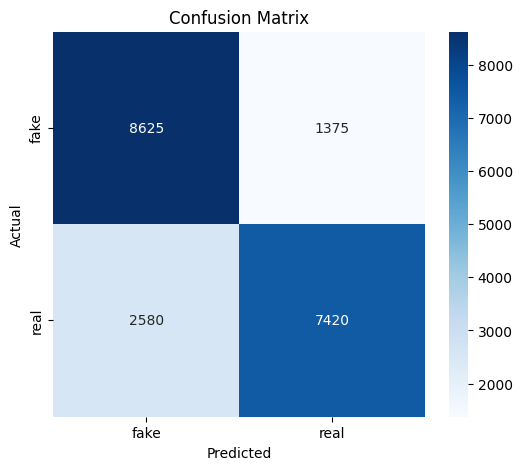

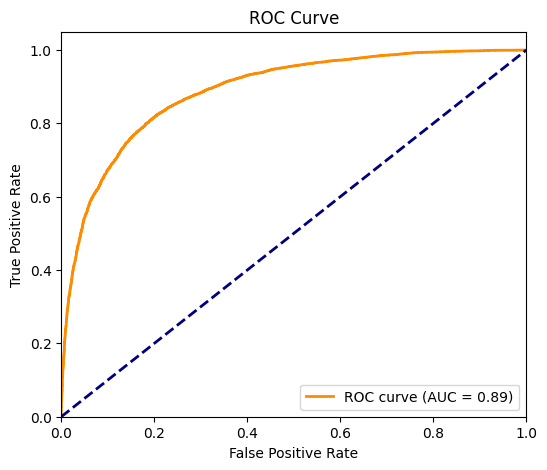

In [11]:
# ==========================================
# 4. FINAL DETAILED EVALUATION
# ==========================================

print("\nGenerating Final Evaluation Report...")
model.eval()

all_labels = []
all_preds = []
all_probs = []

# Iterate through Test Data again to gather full metrics
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to('cpu').numpy()
        
        outputs = model(inputs)
        probs = torch.nn.functional.softmax(outputs, dim=1) # Get probabilities
        _, preds = torch.max(outputs, 1) # Get binary prediction
        
        all_labels.extend(labels)
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy()[:, 1]) # Prob of being 'REAL' (Index 1)

# --- A. Text Report ---
print("\n" + "="*30)
print("CLASSIFICATION REPORT")
print("="*30)
# This prints Precision, Recall, F1-Score for both Real and Fake
print(classification_report(all_labels, all_preds, target_names=class_names))

accuracy = accuracy_score(all_labels, all_preds)
print(f"Overall Accuracy: {accuracy:.4f}")

try:
    auc_score = roc_auc_score(all_labels, all_probs)
    print(f"ROC-AUC Score:    {auc_score:.4f}")
except:
    print("Could not calculate ROC-AUC (Need both classes in test set)")
    auc_score = 0.5

# --- B. Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# --- C. ROC Curve ---
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [12]:
torch.save(model.state_dict(), 'resnet18_deepfake.pth')
print("Model saved as 'resnet18_deepfake.pth' (Refresh files tab if you don't see it)")

Model saved as 'resnet18_deepfake.pth' (Refresh files tab if you don't see it)
